[Google Colaboratory Variant](https://colab.research.google.com/drive/1pymaadPUhSm0T9N5h44ls-mAcrylfa2F)
## Code Modules & Functions

In [1]:
!pip install --upgrade pip \
--user --quiet --no-warn-script-location
!pip install --upgrade neural_structured_learning \
--user --quiet --no-warn-script-location

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import tensorflow_hub as th,tensorflow as tf
import neural_structured_learning as nsl
import h5py,os,pandas as pd,numpy as np
import seaborn as sn,pylab as pl
import tensorflow.keras.callbacks as tkc,\
tensorflow.keras.utils as tku,tensorflow.keras.layers as tkl
import tensorflow.keras.preprocessing.image as tkimg

In [3]:
def images2array(files_path,img_size,
                 preprocess=False,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if preprocess:
            img=tkimg.load_img(
                img_path,grayscale=grayscale)
            img=tkimg.img_to_array(img)
            img=tkimg.smart_resize(
                img,(img_size,img_size))
        else:
            img=tkimg.load_img(
                img_path,target_size=(img_size,img_size))
            img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),
                    dtype='float32')
def labels2array(files_path):
    files_list=sorted(os.listdir(files_path))
    files_split=np.array([el.split('_') 
                          for el in files_list])
    num_labels=files_split.shape[1]-1
    labels=[files_split[:,i] 
            for i in range(num_labels)]
    labels=np.array(labels).astype('int32')
    for i in range(num_labels):
        label_set=list(set(labels[i]))
        replace_dict=\
        dict(zip(label_set,
                 list(range(len(label_set)))))
        labels[i]=[replace_dict.get(x,x) 
                   for x in labels[i]]
    return labels

## Data

In [4]:
files_path='../input/tomato-cultivars/'
img_size=160
names=[['Kumato','Beefsteak','Tigerella',
        'Roma','Japanese Black Trifele',
        'Yellow Pear','Sun Gold','Green Zebra',
        'Cherokee Purple','Oxheart','Blue Berries',
        'San Marzano','Banana Legs',
        'German Orange Strawberry','Supersweet 100']]
images=images2array(files_path,img_size)
labels=labels2array(files_path)
N=images.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]
labels=np.array([labels[i][shuffle_ids]
                 for i in range(labels.shape[0])])
x_test,x_valid,x_train=\
images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=\
labels[:,:n],labels[:,n:2*n],labels[:,2*n:]

=>=>=>=>=>=>=>=>=>=>

In [5]:
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type',
           'label shape','label type'])
df

,train,valid,test
image shape,"(622, 160, 160, 3)","(77, 160, 160, 3)","(77, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(1, 622)","(1, 77)","(1, 77)"
label type,int32,int32,int32


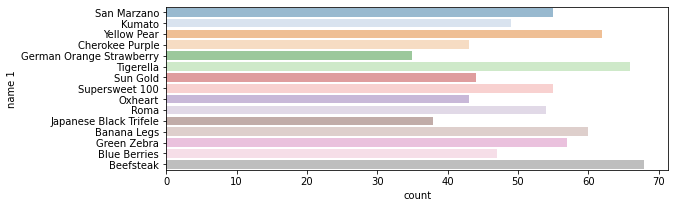

In [6]:
cmap='tab20'
idx=['labels %d'%(i+1) for i in range(labels.shape[0])]
df=pd.DataFrame(labels,index=idx).T
for i in range(labels.shape[0]):
    df['name %d'%(i+1)]=\
    [names[i][l] for l in labels[i]]
fig=pl.figure(figsize=(9,3))    
for i in range(labels.shape[0]):
    ax=fig.add_subplot(labels.shape[0],1,i+1)
    sn.countplot(y='name %s'%(i+1),data=df,
                 palette=cmap,alpha=.5,ax=ax)
pl.show()

## NN Examples

In [7]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,int(3)),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',metrics=['accuracy'],loss=loss)
    return model
def cb(fw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=int(20),verbose=int(2))
    checkpointer=tkc.ModelCheckpoint(
        filepath=fw,verbose=int(2),save_weights_only=True,
        monitor='val_accuracy',mode='max',save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=int(2),patience=int(5),factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [8]:
fw='/tmp/checkpoint'
[handle_base,pixels]=['inception_v3',160]
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [9]:
model=premodel(pixels,1024,mhandle,15,'softmax',
               'sparse_categorical_crossentropy')
history=model.fit(
    x=x_train,y=np.squeeze(y_train),
    batch_size=32,epochs=70,callbacks=cb(fw),
    validation_data=(x_valid,np.squeeze(y_valid)))

Epoch 1/70
20/20 [==============================] - ETA: 0s - loss: 3.5097 - accuracy: 0.1431
Epoch 00001: val_accuracy improved from -inf to 0.09091, saving model to /tmp/checkpoint
20/20 [==============================] - 84s 4s/step - loss: 3.5097 - accuracy: 0.1431 - val_loss: 171.1044 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 2/70
20/20 [==============================] - ETA: 0s - loss: 2.4427 - accuracy: 0.4309
Epoch 00002: val_accuracy did not improve from 0.09091
20/20 [==============================] - 82s 4s/step - loss: 2.4427 - accuracy: 0.4309 - val_loss: 42.1297 - val_accuracy: 0.0779 - lr: 0.0010
Epoch 3/70
20/20 [==============================] - ETA: 0s - loss: 1.7791 - accuracy: 0.5691
Epoch 00003: val_accuracy did not improve from 0.09091
20/20 [==============================] - 81s 4s/step - loss: 1.7791 - accuracy: 0.5691 - val_loss: 7.1724 - val_accuracy: 0.0649 - lr: 0.0010
Epoch 4/70
20/20 [==============================] - ETA: 0s - loss: 1.5098 - accuracy: 0.6

In [10]:
model.load_weights(fw)
model.evaluate(x_test,np.squeeze(y_test))

3/3 [==============================] - 1s 383ms/step - loss: 1.9136 - accuracy: 0.6623


[1.913558006286621, 0.6623376607894897]

In [11]:
[handle_base,pixels]=['mobilenet_v2_100_160',160]
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [12]:
model=premodel(pixels,1024,mhandle,15,'softmax',
               'sparse_categorical_crossentropy')
history=model.fit(
    x=x_train,y=np.squeeze(y_train),
    batch_size=32,epochs=70,callbacks=cb(fw),
    validation_data=(x_valid,np.squeeze(y_valid)))

Epoch 1/70
20/20 [==============================] - ETA: 0s - loss: 2.3359 - accuracy: 0.4293
Epoch 00001: val_accuracy improved from -inf to 0.46753, saving model to /tmp/checkpoint
20/20 [==============================] - 39s 2s/step - loss: 2.3359 - accuracy: 0.4293 - val_loss: 6.0470 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 2/70
20/20 [==============================] - ETA: 0s - loss: 1.1917 - accuracy: 0.7026
Epoch 00002: val_accuracy improved from 0.46753 to 0.49351, saving model to /tmp/checkpoint
20/20 [==============================] - 38s 2s/step - loss: 1.1917 - accuracy: 0.7026 - val_loss: 5.9759 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 3/70
20/20 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.7862
Epoch 00003: val_accuracy improved from 0.49351 to 0.58442, saving model to /tmp/checkpoint
20/20 [==============================] - 38s 2s/step - loss: 1.0444 - accuracy: 0.7862 - val_loss: 4.4361 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 4/70
20/20 [=

In [13]:
model.load_weights(fw)
model.evaluate(x_test,np.squeeze(y_test))

3/3 [==============================] - 0s 138ms/step - loss: 1.9632 - accuracy: 0.6494


[1.9631924629211426, 0.649350643157959]

In [14]:
batch_size=64; img_size=x_train.shape[1]; epochs=30
base_model=tf.keras.Sequential([
    tkl.Input((img_size,img_size,3),name='input'),
    tkl.Conv2D(32,(5,5),padding='same'),
    tkl.Activation('relu'),
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.Conv2D(196,(5,5)),
    tkl.Activation('relu'),    
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.GlobalMaxPooling2D(),    
    tkl.Dense(512),
    tkl.Activation('relu'),
    tkl.Dropout(.25),
    tkl.Dense(128),
    tkl.Activation('relu'),
    tkl.Dropout(.25),
    tkl.Dense(15,activation='softmax')])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(
    optimizer='adam',metrics=['accuracy'],
    loss='sparse_categorical_crossentropy')

In [15]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':np.squeeze(y_train)})\
     .batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':np.squeeze(y_valid)})\
     .batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,verbose=2,
              validation_steps=valid_steps,epochs=epochs)

Epoch 1/30
10/10 - 88s - loss: 3.2603 - sparse_categorical_crossentropy: 2.7180 - sparse_categorical_accuracy: 0.0707 - scaled_adversarial_loss: 0.5423 - val_loss: 3.2368 - val_sparse_categorical_crossentropy: 2.6970 - val_sparse_categorical_accuracy: 0.1562 - val_scaled_adversarial_loss: 0.5398
Epoch 2/30
10/10 - 87s - loss: 3.1394 - sparse_categorical_crossentropy: 2.6167 - sparse_categorical_accuracy: 0.1383 - scaled_adversarial_loss: 0.5227 - val_loss: 3.1096 - val_sparse_categorical_crossentropy: 2.5908 - val_sparse_categorical_accuracy: 0.1250 - val_scaled_adversarial_loss: 0.5188
Epoch 3/30
10/10 - 87s - loss: 2.8180 - sparse_categorical_crossentropy: 2.3458 - sparse_categorical_accuracy: 0.1929 - scaled_adversarial_loss: 0.4722 - val_loss: 2.7535 - val_sparse_categorical_crossentropy: 2.2933 - val_sparse_categorical_accuracy: 0.2031 - val_scaled_adversarial_loss: 0.4602
Epoch 4/30
10/10 - 88s - loss: 2.5010 - sparse_categorical_crossentropy: 2.0806 - sparse_categorical_accuracy

In [16]:
adv_model.evaluate(
    {'input':x_test,'label':np.squeeze(y_test)})

3/3 [==============================] - 3s 1s/step - loss: 1.9295 - sparse_categorical_crossentropy: 1.6011 - sparse_categorical_accuracy: 0.4286 - scaled_adversarial_loss: 0.3284


[1.9295064210891724,
 1.6010961532592773,
 0.4285714328289032,
 0.32841023802757263]